# mdb_to_df

In [1]:
import pyodbc
import os
import pandas as pd
from zipfile import ZipFile


def mdb_to_df(file_name, sql):

    conn_str = (
        r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
        fr'DBQ={file_name};'
    )
    print(conn_str)
    cnxn = pyodbc.connect(conn_str)

    df = pd.read_sql(sql, cnxn)

    print(f'{file_name} Loaded')
    return df


# Cascade

In [2]:
# Determine alarms real periods
def cascade(df):

    df.reset_index(inplace=True, drop=True)
    df['TimeOffMax'] = df.TimeOff.cummax().shift()

    df.at[0, 'TimeOffMax'] = df.at[0, 'TimeOn']

    return df


# looping through turbines and applying cascade method
def apply_cascade(result_sum):

    # Sort by alarm ID
    result_sum.sort_values(['ID'], inplace=True)
    df = result_sum.groupby('StationId').apply(cascade)

    mask_root = (df.TimeOn.values >= df.TimeOffMax.values)
    mask_children = (df.TimeOn.values < df.TimeOffMax.values) & (
        df.TimeOff.values > df.TimeOffMax.values)
    mask_embedded = (df.TimeOff.values <= df.TimeOffMax.values)

    df.loc[mask_root, 'NewTimeOn'] = df.loc[mask_root, 'TimeOn']
    df.loc[mask_children, 'NewTimeOn'] = df.loc[mask_children, 'TimeOffMax']
    df.loc[mask_embedded, 'NewTimeOn'] = df.loc[mask_embedded, 'TimeOff']

    df.drop(columns=['TimeOffMax'], inplace=True)

    df.reset_index(inplace=True, drop=True)

    TimeOff = df.TimeOff
    NewTimeOn = df.NewTimeOn

    df['RealPeriod'] = abs(TimeOff - NewTimeOn)

    mask_siemens = (df['Error Type'] == 1)
    mask_tarec = (df['Error Type'] == 0)

    df['Period Siemens(s)'] = df[mask_siemens].RealPeriod  # .dt.seconds
    df['Period Tarec(s)'] = df[mask_tarec].RealPeriod  # .dt.seconds
    # df['RealPeriod'] = df['RealPeriod'].dt.seconds

    return df


# Read SUM

In [3]:
import numpy as np
from datetime import datetime as dt


def read_sum(period):
    usecols_sum = """
    SELECT CDbl(TimeOn) AS TOn, CDbl(TimeOff) AS TOff,
    StationNr, Alarmcode, ID, Parameter
    FROM tblAlarmLog WHERE TimeOff IS NOT NULL
    union
    SELECT CDbl(TimeOn) AS TOn, TimeOff AS TOff,
    StationNr, Alarmcode, ID, Parameter
    FROM tblAlarmLog WHERE TimeOff IS NULL
    """
    file_name = f'../DATA/SUM/{period}-sum.mdb'
    alarms = mdb_to_df(file_name=file_name, sql=usecols_sum)

    alarms['TOn'] = sqldate_to_datetime(alarms['TOn'])
    alarms['TOff'] = sqldate_to_datetime(alarms['TOff'])

    alarms.rename(columns={'TOn': 'TimeOn',
                           'TOff': 'TimeOff'}, inplace=True)

    alarms = alarms[alarms.StationNr >= 2307405]

    alarms = alarms[
        alarms.StationNr <= 2307535].reset_index(
        drop=True)

    alarms.dropna(subset=['Alarmcode'], inplace=True)

    alarms.reset_index(drop=True, inplace=True)

    alarms.Alarmcode = alarms.Alarmcode.astype(int)

    return alarms


def sqldate_to_datetime(column):
    try:
        column = column.str.replace(',', '.').astype(float)
    except:
        pass
    day_parts = np.modf(column.loc[~column.isna()])
    column = column.fillna(0)

    column.loc[~column.isna()] = (
        dt(1899, 12, 30) +
        day_parts[1].astype('timedelta64[D]', errors='ignore') +
        (day_parts[0] * 86400000).astype('timedelta64[ms]', errors='ignore')
    )
    return column


# Calcul mois

In [4]:
period = '2020-07'

alarms = read_sum(period)

results = pd.read_pickle(f'../DATA/results/{period}.pkl')

alarms.rename(columns={'StationNr': 'StationId'}, inplace=True)

alarms['StationId'] = alarms['StationId'] - 2307404
results['StationId'] = results['StationId'] - 2307404

DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-07-sum.mdb;
../DATA/SUM/2020-07-sum.mdb Loaded


In [5]:
results

,Unnamed: 0,StationId,TimeStamp,RealPeriod,Period 0(s),Period 1(s),UK Text,wtc_kWG1Tot_accum,wtc_kWG1TotE_accum,wtc_ActPower_min,...,EL 20-25,EL_115_left,EL_indefini,EL_wind,Duration lowind(s),EL_wind_start,Duration lowind_start(s),EL_alarm_start,Duration alarm_start(s),EL_indefini_left
0,0,1,2020-07-01 00:10:00,0.0,0.0,0.0,0,396.0,396.0,2236.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,2020-07-01 00:20:00,0.0,0.0,0.0,0,359.0,359.0,1381.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,2020-07-01 00:30:00,0.0,0.0,0.0,0,380.0,380.0,1357.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,2020-07-01 00:40:00,0.0,0.0,0.0,0,347.0,347.0,1374.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,2020-07-01 00:50:00,0.0,0.0,0.0,0,356.0,355.0,1365.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584779,584779,131,2020-07-31 23:20:00,0.0,0.0,0.0,0,95.0,95.0,331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584780,584780,131,2020-07-31 23:30:00,0.0,0.0,0.0,0,109.0,109.0,331.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584781,584781,131,2020-07-31 23:40:00,0.0,0.0,0.0,0,128.0,128.0,479.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584782,584782,131,2020-07-31 23:50:00,0.0,0.0,0.0,0,112.0,112.0,453.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
Frame = pd.DataFrame
c1 = 'Alarmcode'
c2 = 'Error Group'

error_group = pd.concat([Frame({c1: range(901, 2101), c2: 'System'}),
                         Frame({c1: range(2101, 3000), c2: 'Generator'}),
                         Frame({c1: range(3100, 4000), c2: 'Hub'}),
                         Frame({c1: range(4100, 5000), c2: 'Gear'}),
                         Frame({c1: range(5000, 6000), c2: 'Grid'}),
                         Frame({c1: range(6100, 7000), c2: 'Rotor'}),
                         Frame({c1: range(7100, 8000), c2: 'Hydraulics'}),
                         Frame({c1: range(8000, 8400), c2: 'Environement'}),
                         Frame({c1: range(8450, 9000),
                                c2: 'Turbine cond...'}),
                         Frame({c1: range(9100, 10000), c2: 'Brake'}),
                         Frame({c1: range(10100, 11000), c2: 'Yaw'}),
                         Frame({c1: range(11100, 12000), c2: 'PFC'}),
                         Frame({c1: range(12100, 13000), c2: 'Transformer'}),
                         Frame({c1: range(13000, 14000), c2: 'Converter-1'}),
                         Frame({c1: range(14000, 15000), c2: 'Gen.inverter'}),
                         Frame({c1: range(15000, 16000), c2: 'Grid inverter'}),
                         Frame({c1: range(16000, 17000), c2: 'Main bearing'}),
                         Frame({c1: range(17000, 18300), c2: 'Converter-2'}),
                         Frame({c1: range(62001, 64000), c2: 'Controller'}),
                         Frame({c1: range(64000, 65200), c2: 'MISCELLANEOUS'})])


In [7]:
reorder = ['System',
           'Generator',
           'Hub',
           'Gear',
           'Grid',
           'Rotor',
           'Hydraulics',
           'Environement',
           'Turbine cond...',
           'Brake',
           'Yaw',
           'PFC',
           'Transformer',
           'Converter-1',
           'Gen.inverter',
           'Grid inverter',
           'Main bearing',
           'Converter-2',
           'Controller',
           'MISCELLANEOUS']

In [8]:
error_list = pd.read_excel(
    r'Error_Type_List_Las_Update_151209.xlsx',
    usecols=lambda x: x != 'Type Selected')

error_list.Alarmcode = error_list.Alarmcode.astype(int)  # ,errors='ignore'

error_list.drop_duplicates(subset=['Alarmcode'], inplace=True)

error_list = error_list.merge(error_group, on='Alarmcode', how='left')

# ------------------------------------------------------------------------
''' label scada alarms with coresponding error type
and only keep alarm codes in error list'''
result_sum = pd.merge(alarms, error_list[[
                        'Alarmcode', 'Error Type', 'Error Group']],
                        on='Alarmcode',
                        how='inner', sort=False)

# Remove warnings
result_sum = result_sum.loc[result_sum['Error Type'].isin([1, 0])]

# apply cascade
alarms_result_sum = apply_cascade(result_sum)

# only keep  parent alarms
parent_result_sum = alarms_result_sum.query('TimeOn == NewTimeOn')

# dash duree
main_result_sum = alarms_result_sum.query('RealPeriod > @pd.Timedelta(0)')
# main_result_sum['ALL duree'] = main_result_sum['TimeOff'] -main_result_sum['TimeOn']

In [9]:
''' label scada alarms with coresponding error type
and only keep alarm codes in error list'''
result_sum = pd.merge(alarms, error_list[[
                        'Alarmcode', 'Error Type', 'Error Group']],
                        on='Alarmcode',
                        how='inner', sort=False)

# Remove warnings
result_sum = result_sum.loc[result_sum['Error Type'].isin([1, 0])]

# apply cascade
alarms_result_sum = apply_cascade(result_sum)

#only keep  parent alarms
parent_result_sum = alarms_result_sum.query('TimeOn == NewTimeOn')

# dash duree
main_result_sum = alarms_result_sum.query('RealPeriod > @pd.Timedelta(0)')
# main_result_sum['ALL duree'] = main_result_sum['TimeOff'] -main_result_sum['TimeOn']

## Graphe 3 ax5

In [65]:
df_ax5 = (main_result_sum.groupby('Error Group')
                  .agg(Freq=('Alarmcode', 'count'),
                       Duree=('RealPeriod', lambda x: x.sum().total_seconds()/3600))
                  .reindex(reorder)
                  .dropna()
                  .reset_index()
                  )

# df_ax5.plot(kind='bar', x='Error Group', ax=ax5)

## Graphe 4 ax6

In [11]:
df_ax6 = (main_result_sum.groupby('Alarmcode')
                .agg(Freq=('Alarmcode', 'count'),
                     Duration=('RealPeriod',
                               lambda x: x.sum().total_seconds()/3600))
                .sort_values('Duration', ascending=False)
                .head(20)
                .reset_index()
                .sort_values('Duration', ascending=False))

# df_ax6.plot(kind='bar', x='Alarmcode', ax=ax6)


## Graph 6 ax9

In [12]:
df_ax9 = pd.merge((results.groupby('StationId')
                 .agg(Duration_115=('Duration 115(s)',
                                    lambda x: x.sum()/3600),
                      Duration_20_25=('Duration 20-25(s)',
                                      lambda x: x.sum()/3600))
                 .sort_values('Duration_115', ascending=False)
                 # .head(25)
                 .reset_index()
         ),
         (alarms.groupby('StationId')
                .agg(Freq_115=('Alarmcode', lambda x: int(x[x == 115].count()/2)),
                     Freq_25=('Alarmcode', lambda x: x[x == 20].count()))
                .reset_index()
         ),
         on='StationId'
        ).sort_values('Duration_115', ascending=False).head(20)


# df_ax9.plot(kind='bar', x='StationId', ax=ax9)

## table 1 ax1

In [13]:
df_ax1 = pd.DataFrame(columns=['LTA-Lost Time', 'Indispo. Tarec', 'Indispo. ONEE', 'Indispo. Ebop', 'Indispo. Siemens',
                               'Pertes éléctriques \n en MWh', 'Power Boost en MWh', 'Performance moyenne \n des turbines',
                               'MTBF - Mean Time \n Between Failure', 'MTTR - Mean Time \n To Repair', 'MTTI - Mean Time \n To Intervention'],
                     index=['Indicateurs \n annuels :', f'Indicateurs du \n mois {period} :'])

In [14]:
df_ax1

,LTA-Lost Time,Indispo. Tarec,Indispo. ONEE,Indispo. Ebop,Indispo. Siemens,Pertes éléctriques \n en MWh,Power Boost en MWh,Performance moyenne \n des turbines,MTBF - Mean Time \n Between Failure,MTTR - Mean Time \n To Repair,MTTI - Mean Time \n To Intervention
Indicateurs \n annuels :,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Indicateurs du \n mois 2020-07 :,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Calcul Cumul

In [15]:
cumul_alarms = pd.DataFrame()
cumul_results = pd.DataFrame()

for month in range(1, 8):

    month = str(month)

    alarms = read_sum(f'2020-{month.zfill(2)}')
    cumul_alarms = pd.concat([cumul_alarms, alarms])
    # -------------------------------------------------------------------------
    results = pd.read_pickle(f'../DATA/results/2020-{month.zfill(2)}.pkl')
    results = results[['StationId', 'ELNX', 'Duration 115(s)', 'Duration 20-25(s)',
                       'Period 0(s)', 'Period 1(s)',
                       'EL_indefini_left']]
    cumul_results = pd.concat([cumul_results, results])


DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-01-sum.mdb;
../DATA/SUM/2020-01-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-02-sum.mdb;
../DATA/SUM/2020-02-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-03-sum.mdb;
../DATA/SUM/2020-03-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-04-sum.mdb;
../DATA/SUM/2020-04-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-05-sum.mdb;
../DATA/SUM/2020-05-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-06-sum.mdb;
../DATA/SUM/2020-06-sum.mdb Loaded
DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=../DATA/SUM/2020-07-sum.mdb;
../DATA/SUM/2020-07-sum.mdb Loaded


In [210]:
pd.read_pickle(f'../DATA/results/2020-{month.zfill(2)}.pkl').columns

Index(['Unnamed: 0', 'StationId', 'TimeStamp', 'RealPeriod', 'Period 0(s)',
       'Period 1(s)', 'UK Text', 'wtc_kWG1Tot_accum', 'wtc_kWG1TotE_accum',
       'wtc_ActPower_min', 'wtc_ActPower_max', 'wtc_ActPower_mean',
       'Duration 115(s)', 'Duration 20-25(s)', 'wtc_AcWindSp_mean',
       'wtc_ActualWindDirection_mean', '('met_WindSpeedRot_mean', 38)',
       '('met_WindSpeedRot_mean', 39)', '('met_WindSpeedRot_mean', 246)',
       '('met_WinddirectionRot_mean', 38)',
       '('met_WinddirectionRot_mean', 39)',
       '('met_WinddirectionRot_mean', 246)', 'Epot', 'Correction Factor',
       'Available Turbines', 'EL', 'ELX', 'ELNX', 'EL 115', 'EL 20-25',
       'EL_115_left', 'EL_indefini', 'EL_wind', 'Duration lowind(s)',
       'EL_wind_start', 'Duration lowind_start(s)', 'EL_alarm_start',
       'Duration alarm_start(s)', 'EL_indefini_left'],
      dtype='object')

In [16]:
cumul_alarms.rename(columns={'StationNr': 'StationId'}, inplace=True)

cumul_alarms['StationId'] = cumul_alarms['StationId'] - 2307404
cumul_results['StationId'] = cumul_results['StationId'] - 2307404

In [77]:
cumul_result_sum = pd.merge(cumul_alarms, error_list[[
                        'Alarmcode', 'Error Type', 'Error Group']],
                        on='Alarmcode',
                        how='inner', sort=False)

# Remove warnings
cumul_result_sum = cumul_result_sum.loc[cumul_result_sum['Error Type'].isin([1, 0])]

# apply cascade
cumul_alarms_result_sum = apply_cascade(cumul_result_sum)

#only keep  parent alarms
cumul_parent_result_sum = cumul_alarms_result_sum.query('TimeOn	 == NewTimeOn')
  
cumul_main_result_sum = cumul_alarms_result_sum.query('RealPeriod > @pd.Timedelta(0)')

## Graphe 1 ax3

In [78]:
df_ax3 = (cumul_main_result_sum.groupby('Error Group')
                .agg(Freq=('Alarmcode', 'count'),
                     Duree=('RealPeriod', lambda x: x.sum().total_seconds()/3600))
                .sort_values('Freq', ascending=False)
                .reindex(reorder)
                .dropna()
                .reset_index()
                )

# df_ax3.plot(kind='bar', x='Error Group', ax=ax3)

## Graphe 5 ax8

In [19]:
df_ax8 = pd.merge((cumul_results.groupby('StationId')
                       .agg(Duration_115=('Duration 115(s)', lambda x: x.sum()/3600),
                            Duration_20_25=('Duration 20-25(s)', lambda x: x.sum()/3600))
                       .sort_values('Duration_115', ascending=False)
                 # .head(25)
                 .reset_index()
         ),
         (cumul_alarms.groupby('StationId')
                      .agg(Freq_115=('Alarmcode', lambda x: int(x[x == 115].count()/2)),
                           Freq_25=('Alarmcode', lambda x: x[x == 20].count()))
                      .reset_index()
         ),
        ).sort_values('Duration_115', ascending=False).head(20)

# df_ax8.plot(kind='bar', x='StationId', ax=ax8)


## Graphe 7 ax10

In [20]:
cumul_results.columns

Index(['StationId', 'ELNX', 'Duration 115(s)', 'Duration 20-25(s)',
       'Period 0(s)', 'Period 1(s)', 'EL_indefini_left'],
      dtype='object')

In [21]:
df_ax10 = (cumul_results[['StationId','ELNX', 'EL_indefini_left']]
                .groupby('StationId')
                .sum()
                .sort_values('ELNX', ascending=False)
                .head(20)
                .reset_index())


In [22]:
(cumul_results[['StationId','ELNX', 'EL_indefini_left']]
    .groupby('StationId')
    .sum()
    .reset_index()
    .sort_values('ELNX', ascending=False)
    )

,StationId,ELNX,EL_indefini_left
68,69,635108.351676,886.74
33,34,416329.458069,534.38
107,108,404273.800920,23956.62
74,75,386826.508542,2080.48
100,101,367348.544604,12480.42
...,...,...,...
87,88,23023.714389,11736.13
91,92,22743.340845,9077.71
50,51,19452.334067,2762.28
36,37,12884.265362,877.17


# -----------------------------------------------------------------------------------------------
# Dash

In [53]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('bmh')
plt.tight_layout()
# plt.rc('axes', titlesize=50)

<Figure size 432x288 with 0 Axes>

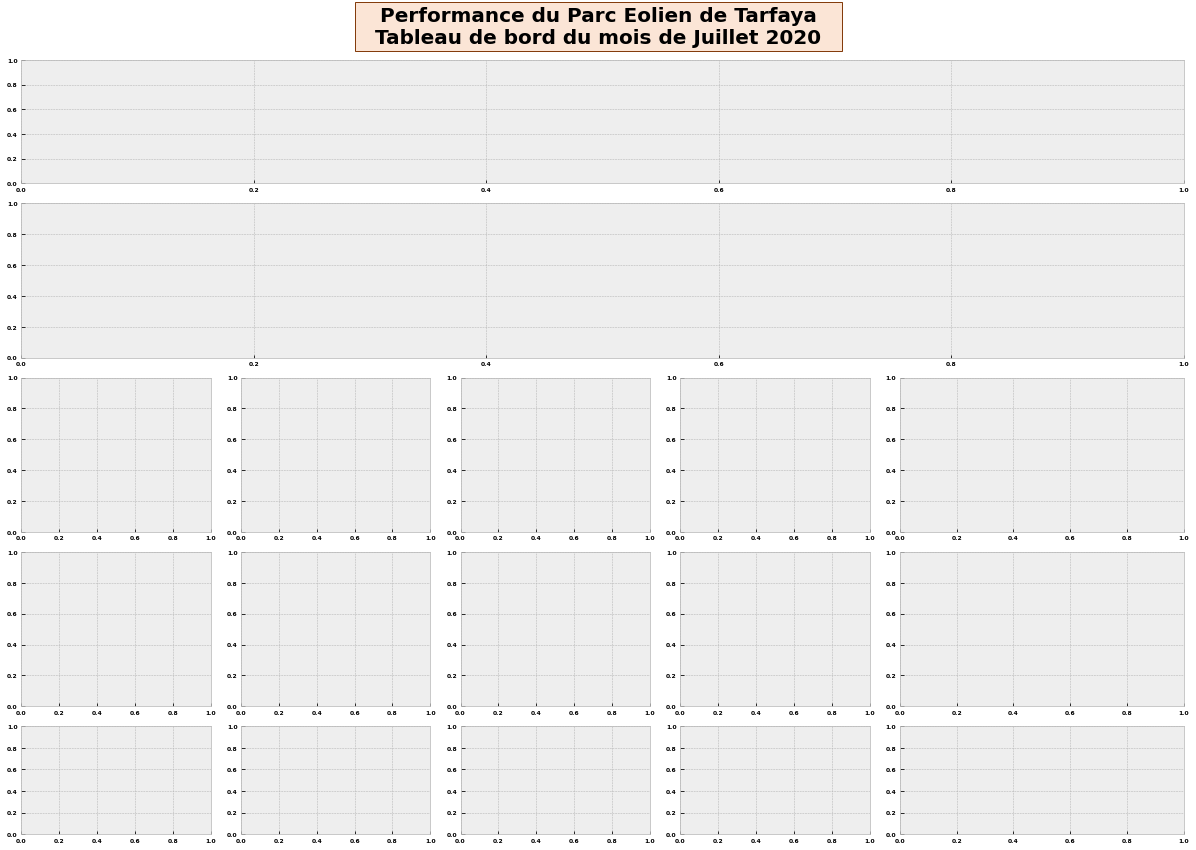

In [99]:
fig = plt.figure(constrained_layout=True, figsize=(22, 16))

# plt.rcParams.keys()
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6


heights = [0.8, 1, 1, 1, 0.7]
widths = [1, 1, 1, 1, 1.5]
gs = fig.add_gridspec(5, 5, height_ratios=heights, width_ratios=widths)


ax1 = fig.add_subplot(gs[0, :])
# ax1.set_title('gs[0, :]')

ax2 = fig.add_subplot(gs[1, :])

ax3 = fig.add_subplot(gs[2, 0])

ax4 = fig.add_subplot(gs[2, 1])

ax5 = fig.add_subplot(gs[2, 2])

ax6 = fig.add_subplot(gs[2, 3])

ax7 = fig.add_subplot(gs[2, 4])

ax8 = fig.add_subplot(gs[3, 0])

ax9 = fig.add_subplot(gs[3, 1])

ax10 = fig.add_subplot(gs[3, 2])

ax11 = fig.add_subplot(gs[3, 3])

ax12 = fig.add_subplot(gs[3, 4])

ax13 = fig.add_subplot(gs[4, 0])

ax14 = fig.add_subplot(gs[4, 1])

ax15 = fig.add_subplot(gs[4, 2])

ax16 = fig.add_subplot(gs[4, 3])

ax17 = fig.add_subplot(gs[4, 4])

fig.suptitle('   Performance du Parc Eolien de Tarfaya   \n Tableau de bord du mois de Juillet 2020 ',
             fontsize=20, fontweight='heavy', fontstretch='ultra-expanded',
             bbox=dict(facecolor='#fbe5d6', edgecolor='#843c0c', linewidth=1))

fig.set_size_inches(16.5, 11.7)


## Format axs

In [94]:
text_box_ticks = dict()

for x in (ax1, ax2, ax7, ax12, ax13, ax14, ax15, ax16, ax17):
    x.set_yticks([]), x.set_xticks([])
    # x.set_axis_off()

ax4.tick_params(labelsize=8, rotation=90)
# ax4.secondary_yaxis('right')



## Add data to axs

In [95]:
ax1.cla()
ax1.set_axis_off()
table1 = ax1.table(cellText=df_ax1.to_numpy().tolist(),
                   colLabels=df_ax1.columns.tolist(),
                   rowLabels=df_ax1.index.tolist(),
                   bbox = [0,0,1,0.7])


table1.auto_set_font_size(False)
table1.set_fontsize(7)
# table1.auto_set_column_width(col=list(range(len(df_ax1.columns))))
table1._cells[(1,-1)].set_width(0.1)
table1._cells[(2,-1)].set_width(0.1)

In [96]:
for i in range(3,10):
    eval(f'ax{i}.cla()')


df_ax3.plot(kind='bar', x='Error Group', ax=ax3, width=0.85)
ax3.set_title('Cumul annuel par type d\'alarme',
                fontsize=8)

df_ax5.plot(kind='bar', x='Error Group', ax=ax5, width=0.85)
ax5.set_title(f'Type d\'alarme {period}',
                fontsize=8)

df_ax6.plot(kind='bar', x='Alarmcode', ax=ax6, width=0.85)
ax6.set_title(f'Alarmes {period}',
                fontsize=8)

df_ax8.plot(kind='bar', x='StationId', ax=ax8, width=0.85)
ax8.set_title('Arrêts turbines : Cumul Annuel',
                fontsize=8)

df_ax9.plot(kind='bar', x='StationId', ax=ax9, width=0.85)
ax9.set_title(f'Arrêts turbines {period}',
                fontsize=8)


ax8.legend(ncol=2, fontsize=7)
ax9.legend(ncol=2, fontsize=7, frameon=True)


In [97]:
from matplotlib.ticker import ScalarFormatter

ax10.cla()
ax10.bar(df_ax10['StationId'].astype('str'), df_ax10['ELNX'], label='ELNX')
ax10.bar(df_ax10['StationId'].astype('str'), df_ax10['EL_indefini_left'], bottom=df_ax10['ELNX'],
       label='EL_indefini_left')

ax10.set_xlabel('StationId')
ax10.set_title('Energie perdue selon FSA cumulée sur \n l\'année 2020 en MWh',
                fontsize=8)
ax10.tick_params(axis='x', labelsize=6, rotation=90)
ax10.tick_params(axis='y', labelsize=5)

sf = ScalarFormatter(useMathText=True)
# sf.set_scientific(True)
sf.set_powerlimits((3, 3))
ax10.yaxis.set_major_formatter(sf)

ax10.yaxis.offsetText.set_fontsize(5)

ax10.legend(fontsize=7)

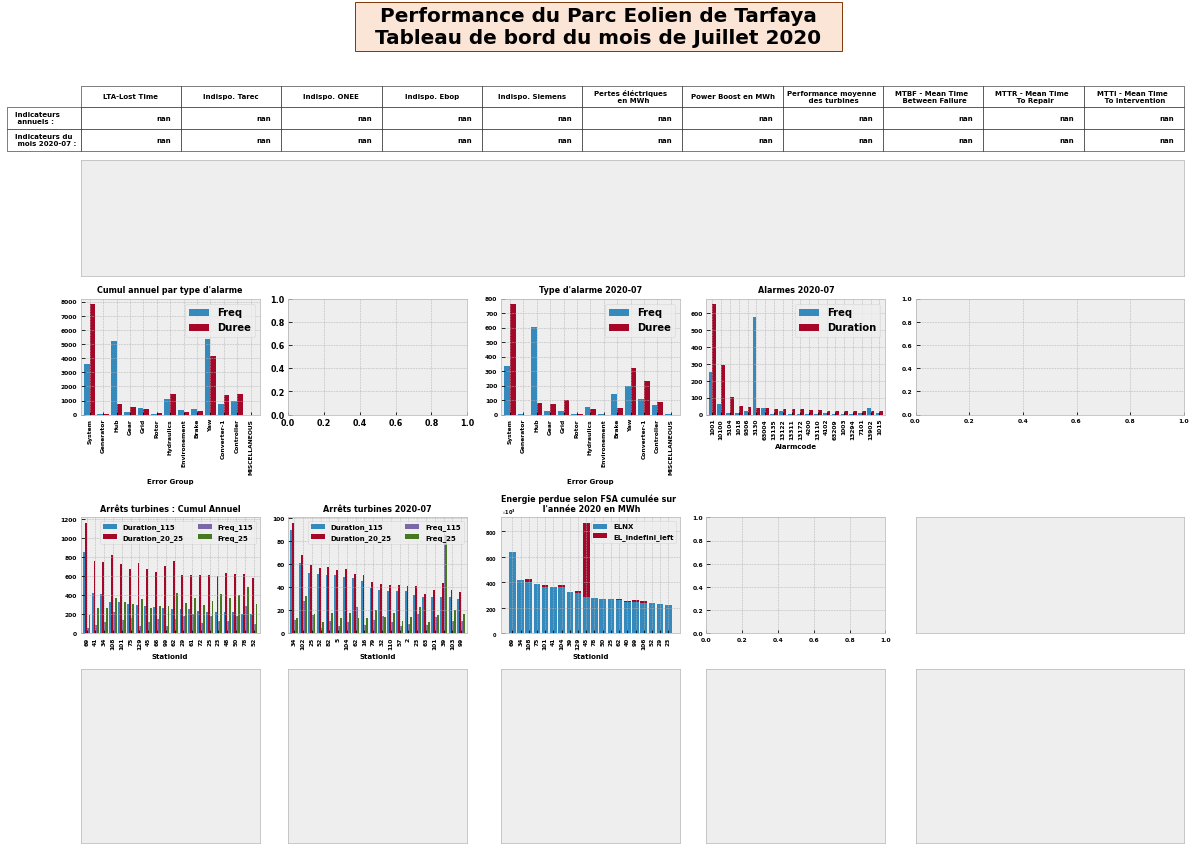

In [98]:
fig

In [61]:
fig.savefig('test.pdf', bbox_inches='tight', pad_inches=0.2)

# Testing figures

In [99]:
import matplotlib as mpl

def mergecells(table, ix0, ix1):
    ix0,ix1 = np.asarray(ix0), np.asarray(ix1)
    d = ix1 - ix0
    if not (0 in d and 1 in np.abs(d)):
        raise ValueError("ix0 and ix1 should be the indices of adjacent cells. ix0: %s, ix1: %s" % (ix0, ix1))

    if d[0]==-1:
        edges = ('BRL', 'TRL')
    elif d[0]==1:
        edges = ('TRL', 'BRL')
    elif d[1]==-1:
        edges = ('BTR', 'BTL')
    else:
        edges = ('BTL', 'BTR')

    # hide the merged edges
    for ix,e in zip((ix0, ix1), edges):
        table[ix[0], ix[1]].visible_edges = e

    txts = [table[ix[0], ix[1]].get_text() for ix in (ix0, ix1)]
    tpos = [np.array(t.get_position()) for t in txts]

    # center the text of the 0th cell between the two merged cells
    trans = (tpos[1] - tpos[0])/2
    if trans[0] > 0 and txts[0].get_ha() == 'right':
        # reduce the transform distance in order to center the text
        trans[0] /= 2
    elif trans[0] < 0 and txts[0].get_ha() == 'right':
        # increase the transform distance...
        trans[0] *= 2

    txts[0].set_transform(mpl.transforms.Affine2D().translate(*trans))

    # hide the text in the 1st cell
    txts[1].set_visible(False)

In [469]:
import numpy as np
import matplotlib.pyplot as plt


data = [[ 66386, 174296,  75131, 577908,  32015],
        [ 58230, 381139,  78045,  99308, 160454],
        [ 89135,  80552, 152558, 497981, 603535],
        [ 78415,  81858, 150656, 193263,  69638],
        [139361, 331509, 343164, 781380,  52269]]

columns = ('Freeze', 'Wind', 'Flood', 'Quake', 'Hail')
rows = [f'{x} year' for x in (100, 50, 20, 10, 5)]


# Add a table at the bottom of the axes
ax1.cla()

for x in (ax1, ax2, ax7, ax12, ax13, ax14, ax15, ax16, ax17):
    x.set_axis_off()

table = ax1.table(cellText=np.vstack([columns, data]),
                #   rowLabels=rows,
                #   colLabels=columns,
                  loc='center',
                  bbox = [0,0,1,1])

# mergecells(table, (1,0), (0,0))
# mergecells(table, (1,1), (0,1))
# mergecells(table, (0,2), (0,3))

# ax1.show()

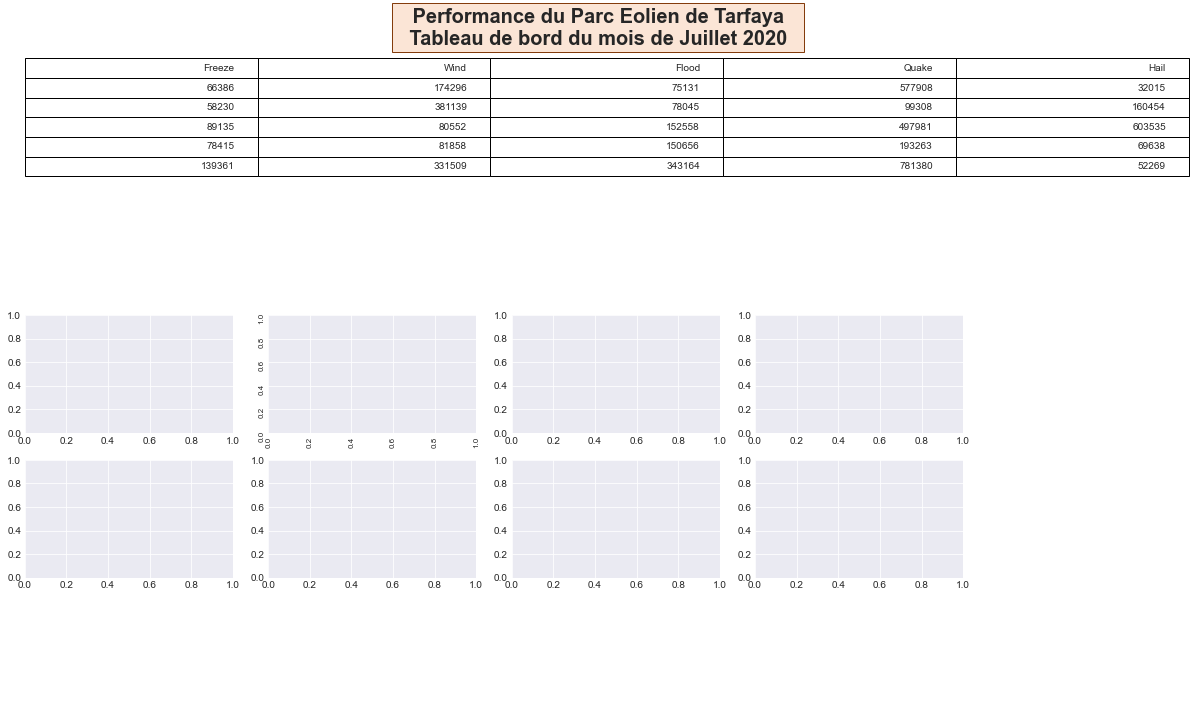

In [470]:
ax1.figure

### -----------------------------------------------------------------------------------------------
### Pandas dataframe to matplotlib table

In [475]:
df = (main_result_sum.groupby('Station')
                .sum()
                .head(5))

df

,Alarmcode,ID
StationNr,,
2307405,36527,17905792
2307406,37528,20950079
2307407,44326,45067457
2307408,183002,66048558
2307409,60010,68652519


In [481]:
ax1.cla()
ax1.set_axis_off()

for x in (ax1, ax2, ax7, ax12, ax13, ax14, ax15, ax16, ax17):
    x.set_yticks([]), x.set_xticks([])

pd.plotting.table(ax1, df, colLabels=[], bbox = [0,0,1,1])

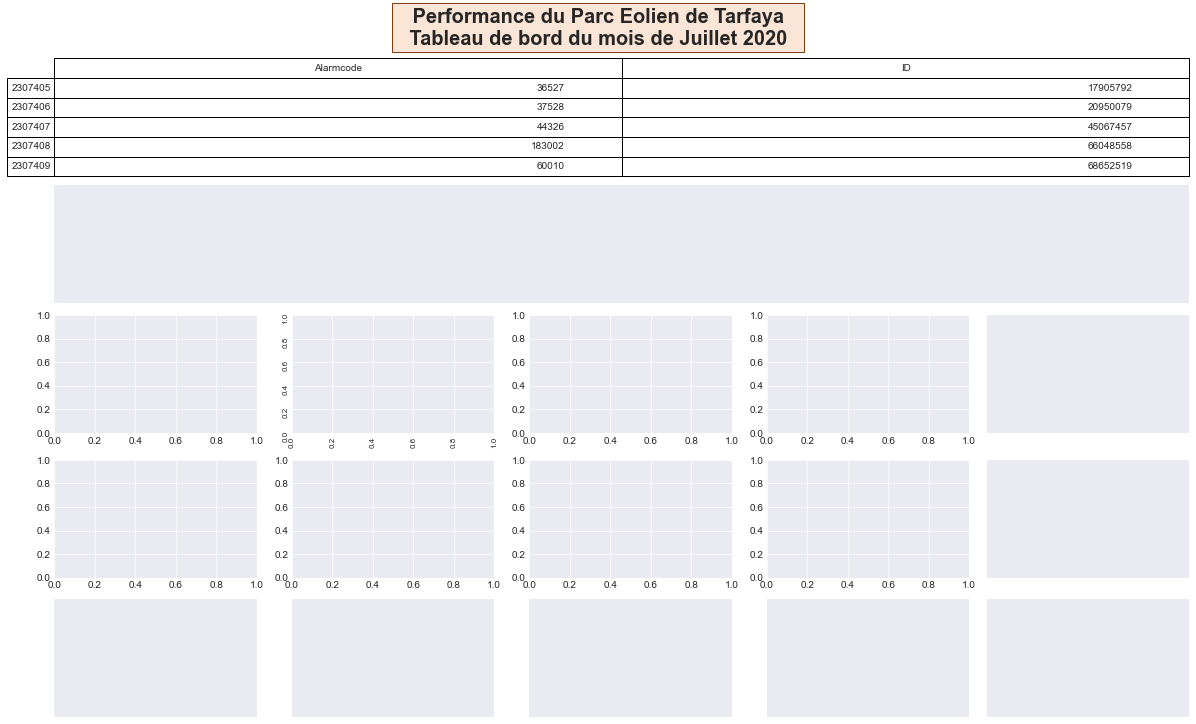

In [482]:
fig

### ----------------------------------------------------------------------------------------------------

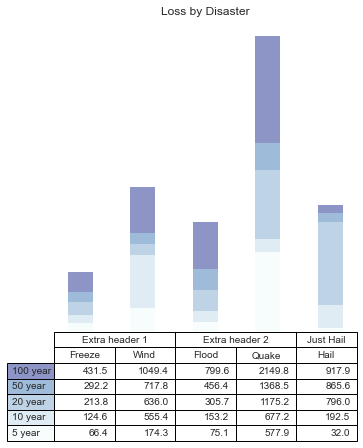

In [417]:


data = [[  66386,  174296,   75131,  577908,   32015],
        [  58230,  381139,   78045,   99308,  160454],
        [  89135,   80552,  152558,  497981,  603535],
        [  78415,   81858,  150656,  193263,   69638],
        [ 139361,  331509,  343164,  781380,   52269]]

columns = ('Freeze', 'Wind', 'Flood', 'Quake', 'Hail')
rows = ['%d year' % x for x in (100, 50, 20, 10, 5)]

values = np.arange(0, 2500, 500)
value_increment = 1000

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.array([0.0] * len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(['%1.1f' % (x/1000.0) for x in y_offset])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add headers and a table at the bottom of the axes
header_0 = plt.table(cellText=[['']*2],
                     colLabels=['Extra header 1', 'Extra header 2'],
                     loc='bottom',
                     bbox=[0, -0.1, 0.8, 0.1]
                     )

header_1 = plt.table(cellText=[['']],
                     colLabels=['Just Hail'],
                     loc='bottom',
                     bbox=[0.8, -0.1, 0.2, 0.1]
                     )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom',
                      bbox=[0, -0.35, 1.0, 0.3]
                      )

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=-0.2)

plt.ylabel("Loss in ${0}'s".format(value_increment))
plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Loss by Disaster')

plt.show()

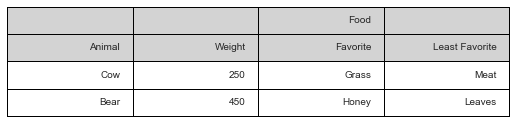

In [450]:
df = pd.DataFrame()
df['Animal'] = ['Cow', 'Bear']
df['Weight'] = [250, 450]
df['Favorite'] = ['Grass', 'Honey']
df['Least Favorite'] = ['Meat', 'Leaves']

fig = plt.figure(figsize=(9,2))
ax=fig.gca()
ax.axis('off')
r,c = df.shape

# ensure consistent background color
ax.table(cellColours=[['lightgray']] + [['none']], bbox=[0,0,1,1])

# plot the real table
table = ax.table(cellText=np.vstack([['', '', 'Food', ''], df.columns, df.values]), 
                 cellColours=[['none']*c]*(2 + r), bbox=[0, 0, 1, 1])

# need to draw here so the text positions are calculated
fig.canvas.draw()

In [453]:
np.vstack([['', '', 'Food', ''], df.columns, df.values])

array([['', '', 'Food', ''],
       ['Animal', 'Weight', 'Favorite', 'Least Favorite'],
       ['Cow', 250, 'Grass', 'Meat'],
       ['Bear', 450, 'Honey', 'Leaves']], dtype=object)

In [454]:
[['', '', 'Food', ''], df.columns, df.values]

[['', '', 'Food', ''],
 Index(['Animal', 'Weight', 'Favorite', 'Least Favorite'], dtype='object'),
 array([['Cow', 250, 'Grass', 'Meat'],
        ['Bear', 450, 'Honey', 'Leaves']], dtype=object)]

# Export Data to excel

In [401]:
with pd.ExcelWriter('output.xlsx') as writer:  

    df_ax1.to_excel(writer, index=True, sheet_name='ax1')

    df_ax3.to_excel(writer, index=False, sheet_name='ax3')

    df_ax5.to_excel(writer, index=False, sheet_name='ax5')

    df_ax6.to_excel(writer, index=False, sheet_name='ax6')

    df_ax8.to_excel(writer, index=False, sheet_name='ax8')

    df_ax9.to_excel(writer, index=False, sheet_name='ax9')

    df_ax10.to_excel(writer, index=False, sheet_name='ax10')